In [2]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import pytensor.tensor as pt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

team_name_to_abbr = {
    'Arizona': 'ARI',
    'Atlanta': 'ATL',
    'Baltimore': 'BAL',
    'Boston': 'BOS',
    'Chi. Cubs': 'CHC',
    'Chi. White Sox': 'CHW',
    'Cincinnati': 'CIN',
    'Cleveland': 'CLE',
    'Colorado': 'COL',
    'Detroit': 'DET',
    'Houston': 'HOU',
    'Kansas City': 'KCR',
    'LA Angels': 'LAA',
    'LA Dodgers': 'LAD',
    'Miami': 'MIA',
    'Milwaukee': 'MIL',
    'Minnesota': 'MIN',
    'NY Mets': 'NYM',
    'NY Yankees': 'NYY',
    'Oakland': 'OAK',
    'Philadelphia': 'PHI',
    'Pittsburgh': 'PIT',
    'San Diego': 'SDP',
    'San Francisco': 'SFG',
    'Seattle': 'SEA',
    'St. Louis': 'STL',
    'Tampa Bay': 'TBR',
    'Texas': 'TEX',
    'Toronto': 'TOR',
    'Washington': 'WSN',
    'Athletics': 'OAK',  # for inconsistency
}


In [3]:
df = pd.read_csv('master_df.csv')
df['homeTeam_abbr'] = df['homeTeam'].map(team_name_to_abbr)
df['awayTeam_abbr'] = df['awayTeam'].map(team_name_to_abbr)
df

,gameId,startDate,homeTeam,awayTeam,homePitcher,awayPitcher,homeScore,awayScore,betmgm_opening_homeOdds,betmgm_opening_awayOdds,...,awayTeam_batting_avg,homePitcher_normalized,awayPitcher_normalized,game_year,homePitcher_era,awayPitcher_era,alpha,beta,gamma,X
0,259014,2022-05-21T00:10:00+00:00,Milwaukee,Washington,Eric Lauer,Erick Fedde,7,0,-190.0,155.0,...,0.249616,Eric Lauer,Erick Fedde,2022,2.16,4.08,1.972308,0.934555,1.888889,1
1,259007,2022-05-21T00:10:00+00:00,Houston,Texas,Cristian Javier,Martin Perez,0,3,-185.0,150.0,...,0.221405,Cristian Javier,Martin Perez,2022,2.87,1.64,1.318565,1.045509,0.571429,0
2,259026,2022-05-21T17:05:00+00:00,NY Yankees,Chi. White Sox,Nestor Cortes,Dallas Keuchel,7,5,-225.0,180.0,...,0.231073,Nestor Cortes,Dallas Keuchel,2022,1.35,5.54,1.474000,1.062145,4.103704,1
3,259023,2022-05-21T19:07:00+00:00,Toronto,Cincinnati,Alek Manoah,Hunter Greene,3,1,-250.0,200.0,...,0.218593,Alek Manoah,Hunter Greene,2022,1.71,6.21,1.861592,1.071855,3.631579,1
4,265633,2022-05-21T19:10:00+00:00,Colorado,NY Mets,German Marquez,Carlos Carrasco,1,5,-105.0,-115.0,...,0.252246,German Marquez,Carlos Carrasco,2022,6.16,3.73,0.747692,1.045761,0.605519,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,301021,2024-08-21T00:10:00+00:00,Kansas City,LA Angels,Cole Ragans,Tyler Anderson,5,9,-210.0,170.0,...,0.234300,Cole Ragans,Tyler Anderson,2024,5.92,3.40,1.296037,1.094678,0.574324,0
2347,301022,2024-08-21T00:10:00+00:00,Houston,Boston,Ronel Blanco,Nick Pivetta,5,6,-135.0,110.0,...,0.261592,Ronel Blanco,Nick Pivetta,2024,3.14,4.61,1.038168,0.998605,1.468153,0
2348,301034,2024-08-21T01:40:00+00:00,San Diego,Minnesota,Martin Perez,Bailey Ober,7,5,100.0,-120.0,...,0.251004,Martin Perez,Bailey Ober,2024,5.20,3.54,1.019784,1.056716,0.680769,1
2349,301025,2024-08-21T01:45:00+00:00,San Francisco,Chi. White Sox,Robbie Ray,Davis Martin,4,1,-250.0,200.0,...,0.219851,Robbie Ray,Davis Martin,2024,3.71,3.22,2.152542,1.106113,0.867925,1


In [4]:
# Convert startDate to timezone-aware datetime
df['startDate'] = pd.to_datetime(df['startDate'], utc=True)

# Define start and end of the season with same timezone
season_start = pd.to_datetime('2022-05-20', utc=True)
season_end = pd.to_datetime('2022-08-20', utc=True)

# Compute linear progress
df['progress'] = (df['startDate'] - season_start) / (season_end - season_start)
df['progress'] = df['progress'].clip(lower=0, upper=1)  # Ensure values are in [0, 1]
df

,gameId,startDate,homeTeam,awayTeam,homePitcher,awayPitcher,homeScore,awayScore,betmgm_opening_homeOdds,betmgm_opening_awayOdds,...,homePitcher_normalized,awayPitcher_normalized,game_year,homePitcher_era,awayPitcher_era,alpha,beta,gamma,X,progress
0,259014,2022-05-21 00:10:00+00:00,Milwaukee,Washington,Eric Lauer,Erick Fedde,7,0,-190.0,155.0,...,Eric Lauer,Erick Fedde,2022,2.16,4.08,1.972308,0.934555,1.888889,1,0.010945
1,259007,2022-05-21 00:10:00+00:00,Houston,Texas,Cristian Javier,Martin Perez,0,3,-185.0,150.0,...,Cristian Javier,Martin Perez,2022,2.87,1.64,1.318565,1.045509,0.571429,0,0.010945
2,259026,2022-05-21 17:05:00+00:00,NY Yankees,Chi. White Sox,Nestor Cortes,Dallas Keuchel,7,5,-225.0,180.0,...,Nestor Cortes,Dallas Keuchel,2022,1.35,5.54,1.474000,1.062145,4.103704,1,0.018607
3,259023,2022-05-21 19:07:00+00:00,Toronto,Cincinnati,Alek Manoah,Hunter Greene,3,1,-250.0,200.0,...,Alek Manoah,Hunter Greene,2022,1.71,6.21,1.861592,1.071855,3.631579,1,0.019527
4,265633,2022-05-21 19:10:00+00:00,Colorado,NY Mets,German Marquez,Carlos Carrasco,1,5,-105.0,-115.0,...,German Marquez,Carlos Carrasco,2022,6.16,3.73,0.747692,1.045761,0.605519,0,0.019550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,301021,2024-08-21 00:10:00+00:00,Kansas City,LA Angels,Cole Ragans,Tyler Anderson,5,9,-210.0,170.0,...,Cole Ragans,Tyler Anderson,2024,5.92,3.40,1.296037,1.094678,0.574324,0,1.000000
2347,301022,2024-08-21 00:10:00+00:00,Houston,Boston,Ronel Blanco,Nick Pivetta,5,6,-135.0,110.0,...,Ronel Blanco,Nick Pivetta,2024,3.14,4.61,1.038168,0.998605,1.468153,0,1.000000
2348,301034,2024-08-21 01:40:00+00:00,San Diego,Minnesota,Martin Perez,Bailey Ober,7,5,100.0,-120.0,...,Martin Perez,Bailey Ober,2024,5.20,3.54,1.019784,1.056716,0.680769,1,1.000000
2349,301025,2024-08-21 01:45:00+00:00,San Francisco,Chi. White Sox,Robbie Ray,Davis Martin,4,1,-250.0,200.0,...,Robbie Ray,Davis Martin,2024,3.71,3.22,2.152542,1.106113,0.867925,1,1.000000


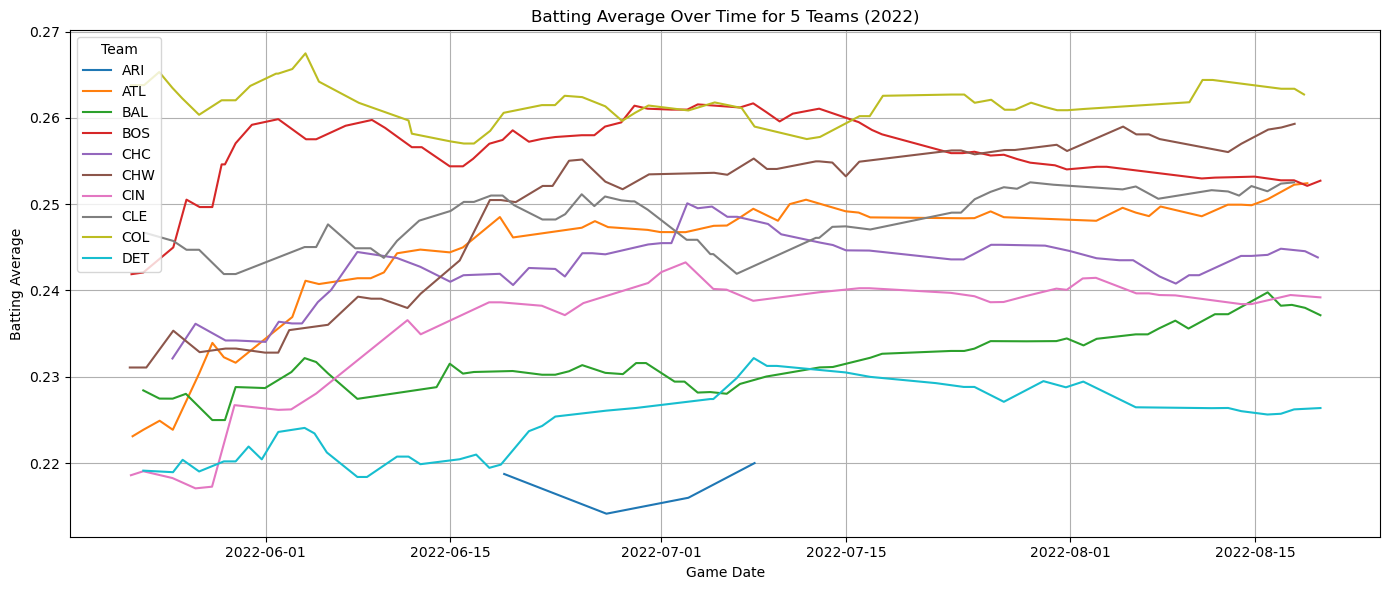

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Define parameters
teams = ["ATL", "LAD", "NYY", "HOU", "TOR"]  # example set of 5 teams
teams = ['ARI', 'ATL', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET']

year = 2022

# Define season date range
start_bound = pd.Timestamp(f"{year}-05-20", tz="UTC")
end_bound = pd.Timestamp(f"{year}-08-20", tz="UTC")

plt.figure(figsize=(14, 6))

for team_abbr in teams:
    # Filter data for team within date range
    df_team = df[
        (df['startDate'] >= start_bound) &
        (df['startDate'] <= end_bound) &
        ((df['homeTeam_abbr'] == team_abbr) | (df['awayTeam_abbr'] == team_abbr)) &
        (df['year'] == year)
    ].copy()

    # Sort by date
    df_team.sort_values('startDate', inplace=True)

    # Extract team-specific batting average
    df_team['bat_avg'] = df_team.apply(
        lambda row: row['homeTeam_batting_avg'] if row['homeTeam_abbr'] == team_abbr else row['awayTeam_batting_avg'],
        axis=1)

    # Plot
    plt.plot(df_team['startDate'], df_team['bat_avg'], label=team_abbr)

# Finalize plot
plt.title(f"Batting Average Over Time for 5 Teams ({year})")
plt.xlabel("Game Date")
plt.ylabel("Batting Average")
plt.legend(title="Team")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from sklearn.model_selection import train_test_split

# ------------------------------
# Data Preparation
# ------------------------------
# Ensure numeric types
df['alpha'] = pd.to_numeric(df['alpha'], errors='coerce')
df['beta'] = pd.to_numeric(df['beta'], errors='coerce')
df['gamma'] = pd.to_numeric(df['gamma'], errors='coerce')
df['X'] = pd.to_numeric(df['X'], errors='coerce')

# Filter out invalid rows
df_clean = df[np.isfinite(df['alpha']) & np.isfinite(df['beta']) & np.isfinite(df['gamma']) & np.isfinite(df['X'])].copy()
df_clean = df_clean.reset_index(drop=True)

# ------------------------------
# Train/Validation Split
# ------------------------------
train_df, val_df = train_test_split(df_clean, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# ------------------------------
# Extract Train Data
# ------------------------------
alpha_data = np.clip(train_df['alpha'].astype(float).values, 1e-6, None)
beta_data = np.clip(train_df['beta'].astype(float).values, 1e-6, None)
gamma_data = np.clip(train_df['gamma'].astype(float).values, 0.2, 5)
X_data = train_df['X'].astype(int).values

# ------------------------------
# PyMC Model with Uniform m
# ------------------------------
with pm.Model() as model:
    # Priors on exponents
    r1 = pm.Uniform('r1', lower=-1, upper=4)
    r2 = pm.Uniform('r2', lower=-4, upper=4)
    r3 = pm.Uniform('r3', lower=-1, upper=4)
    delta = pm.Uniform('delta', lower=0, upper=4)

    # Prior for log_m, exponentiated and clipped to avoid explosion
    log_m = pm.Normal("log_m", mu=2.5, sigma=1.0)
    m = pm.Deterministic("m", pm.math.minimum(pm.math.exp(log_m), 50.0))

    # Relative strength
    lambda_ = alpha_data ** r1 * beta_data ** r2 * gamma_data ** r3
    lambda_delta = lambda_ * delta

    # Beta shape parameters
    a = pm.Deterministic("a", m * lambda_delta)
    b = pm.Deterministic("b", m)

    # Win probability
    p_s = pm.Beta('p_s', alpha=a, beta=b, shape=len(X_data))

    # Likelihood
    X_obs = pm.Bernoulli('X_obs', p=p_s, observed=X_data)

    # Sample
    trace = pm.sample(
        draws=1000,
        tune=500,
        target_accept=0.95,
        cores=4,
        random_seed=42,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r1, r2, r3, delta, log_m, p_s]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 24 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
# Get posterior samples of a and b
a_samples = trace.posterior['a']
b_samples = trace.posterior['b']

# Summary stats
a_mean = a_samples.mean(dim=("chain", "draw"))
b_mean = b_samples.mean(dim=("chain", "draw"))

print("Average a (across observations):", a_mean.values.mean())
print("Average b (across observations):", b_mean.values.mean())


Average a (across observations): 11.736821251226
Average b (across observations): 10.127327199690338


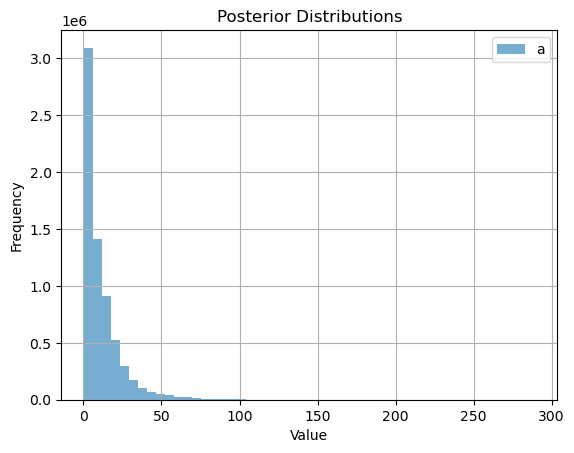

In [8]:
import matplotlib.pyplot as plt

a_flat = a_samples.stack(sample=("chain", "draw")).values.flatten()
b_flat = b_samples.stack(sample=("chain", "draw")).values.flatten()

plt.hist(a_flat, bins=50, alpha=0.6, label='a')
#plt.hist(b_flat, bins=50, alpha=0.6, label='b')
plt.legend()
plt.title("Posterior Distributions")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [9]:
from scipy.stats import gamma

# Fit gamma distributions
a_fit_alpha, a_fit_loc, a_fit_beta = gamma.fit(a_flat, floc=0)
b_fit_alpha, b_fit_loc, b_fit_beta = gamma.fit(b_flat, floc=0)

print("Gamma fit for a:")
print(f"  shape (α) = {a_fit_alpha:.2f}")
print(f"  scale (θ) = {a_fit_beta:.2f}")
print(f"  mean ≈ {a_fit_alpha * a_fit_beta:.2f}")

print("\nGamma fit for b:")
print(f"  shape (α) = {b_fit_alpha:.2f}")
print(f"  scale (θ) = {b_fit_beta:.2f}")
print(f"  mean ≈ {b_fit_alpha * b_fit_beta:.2f}")

Gamma fit for a:
  shape (α) = 1.28
  scale (θ) = 9.14
  mean ≈ 11.74

Gamma fit for b:
  shape (α) = 1.53
  scale (θ) = 6.64
  mean ≈ 10.13


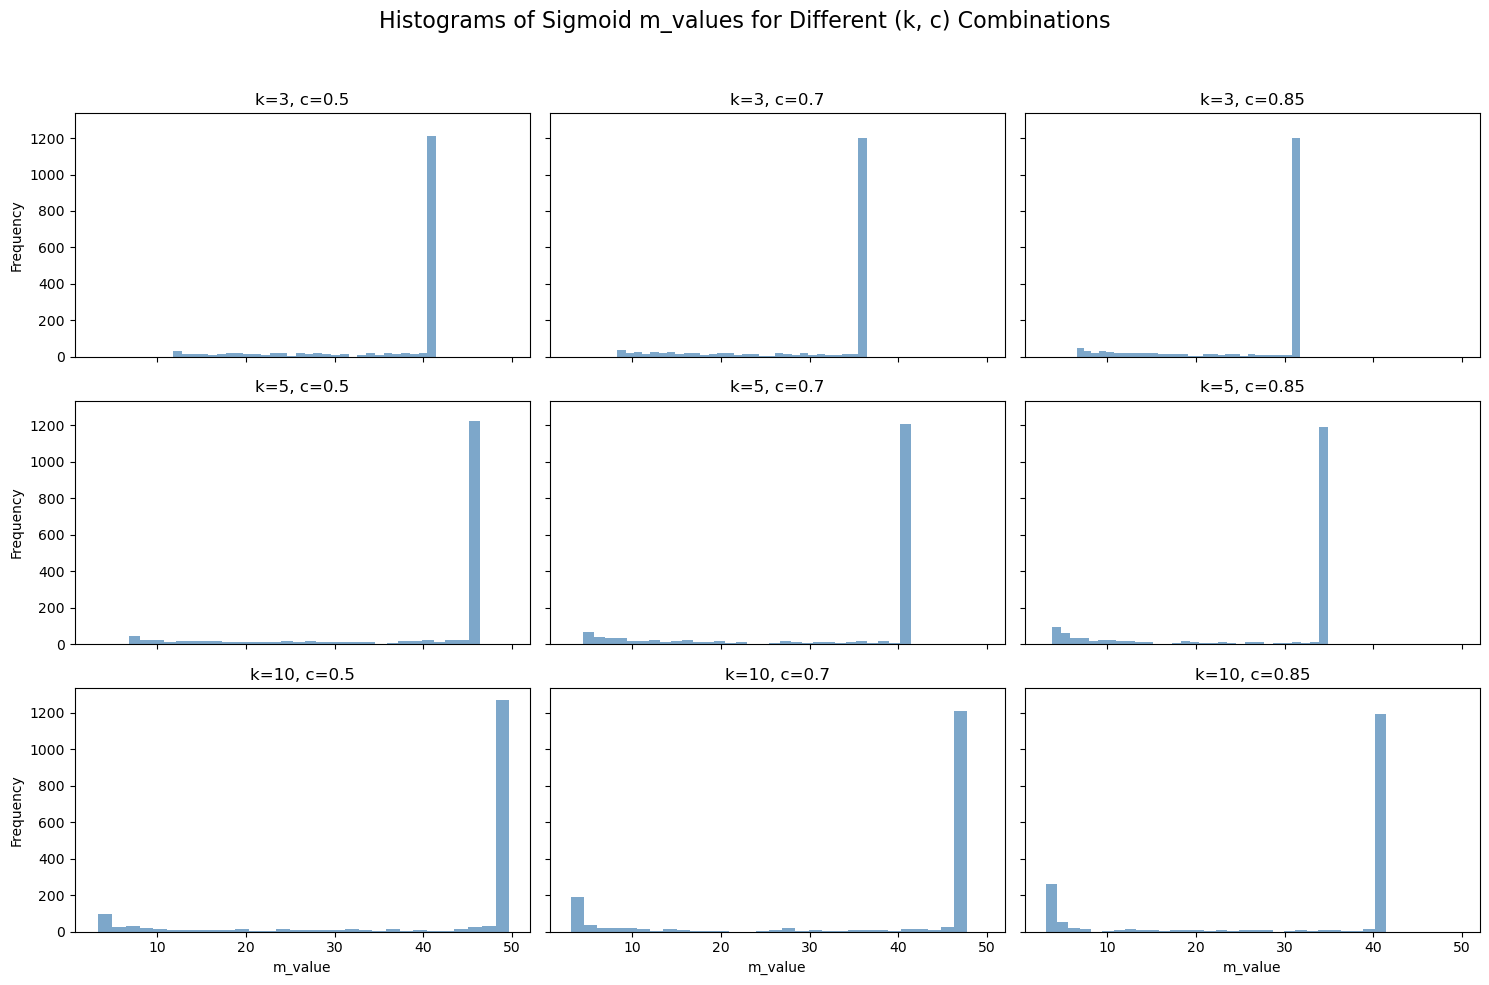

In [ ]:
k_values = [3, 5, 10]
c_values = [0.5, 0.7, 0.85]

# Plot grid
fig, axes = plt.subplots(len(k_values), len(c_values), figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle("Histograms of Sigmoid m_values for Different (k, c) Combinations", fontsize=16)

# Loop through each subplot
for i, k in enumerate(k_values):
    for j, c in enumerate(c_values):
        ax = axes[i, j]
        m_vals = sigmoid_ramp(progress_data, k=k, c=c)
        ax.hist(m_vals, bins=30, alpha=0.7, color='steelblue')
        ax.set_title(f"k={k}, c={c}")
        if i == len(k_values) - 1:
            ax.set_xlabel("m_value")
        if j == 0:
            ax.set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [15]:
import numpy as np

def predict_win_probability_from_trace(trace, alpha, beta, gamma):
    """
    Predict posterior win probabilities using a trained PyMC trace 
    and new alpha, beta, gamma inputs.
    
    Parameters:
        trace: ArviZ InferenceData object (from pm.sample)
        alpha, beta, gamma: np.arrays of shape (n_games,)
    
    Returns:
        p_mean: Posterior mean win probabilities (n_games,)
        p_samples: Posterior samples (n_samples, n_games)
    """
    posterior = trace.posterior
    r1 = posterior['r1'].stack(sample=("chain", "draw")).values
    r2 = posterior['r2'].stack(sample=("chain", "draw")).values
    r3 = posterior['r3'].stack(sample=("chain", "draw")).values
    delta = posterior['delta'].stack(sample=("chain", "draw")).values
    m = posterior['m'].stack(sample=("chain", "draw")).values

    n_samples = len(r1)
    n_games = len(alpha)

    # Expand new data
    alpha_exp = np.tile(alpha, (n_samples, 1))
    beta_exp = np.tile(beta, (n_samples, 1))
    gamma_exp = np.tile(gamma, (n_samples, 1))

    # Forward pass
    lambda_ = (alpha_exp ** r1[:, None]) * (beta_exp ** r2[:, None]) * (gamma_exp ** r3[:, None])
    lambda_delta = lambda_ * delta[:, None]

    a = m[:, None] * lambda_delta
    b = m[:, None]

    # Posterior win probabilities
    p_samples = np.random.beta(a, b)
    p_mean = p_samples.mean(axis=0)

    return p_mean, p_samples

# Prepare validation data
val_alpha = np.clip(val_df['alpha'].astype(float).values, 1e-6, None)
val_beta = np.clip(val_df['beta'].astype(float).values, 1e-6, None)
val_gamma = np.clip(val_df['gamma'].astype(float).values, 0.2, 5)

# Get predictions
p_mean, p_samples = predict_win_probability_from_trace(trace, val_alpha, val_beta, val_gamma)

# Binary score (hard and soft)
val_X = val_df['X'].astype(int).values
p_hard = (p_mean > 0.5).astype(int)

score_hard = 1 - np.mean((p_hard - val_X) ** 2)
score_soft = 1 - np.mean((p_mean - val_X) ** 2)

print("Validation Score (Hard):", score_hard)
print("Validation Score (Soft):", score_soft)

Validation Score (Hard): 0.5721040189125295
Validation Score (Soft): 0.7605230061489677
